In [211]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

In [212]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = ["../data2/bicep_curl/bicep_adam_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv", 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv", 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv", 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv", 
                  "../data2/row/row_adam_set1_reps10_1.csv", 
                  "../data2/row/row_andrew_set1_reps10_1.csv", 
                  "../data2/row/row_anuj_set1_rep10_1.csv", 
                  "../data2/row/row_jake_set1_reps12_1.csv", 
                  "../data2/row/row_kamyar_set1_reps10_1.csv", 
                  "../data2/row/row_mike_set1_reps10_1.csv", 
                  "../data2/row/row_suzan_set1_reps10_1.csv", 
                  "../data2/row/row_udai_set1_reps12_1.csv", 
                  "../data2/dead/dead_adam_set1_reps10_1.csv", 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv", 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv", 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv", 
                  "../data2/dead/dead_mike_set1_reps10_1.csv", 
                  "../data2/squat/squat_adam_set1_reps10_1.csv", 
                  "../data2/squat/squat_andrew_set1_reps10_1.csv", 
                  "../data2/squat/squat_anuj_set1_rep10_1.csv", 
                  "../data2/squat/squat_jake_set1_reps10_1.csv", 
                  "../data2/squat/squat_kamyar_set1_reps10_1.csv", 
                  "../data2/squat/squat_mike_set1_reps10_1.csv", 
                  "../data2/squat/squat_suzan_set1_reps10_1.csv", 
                  "../data2/squat/squat_udai_set1_reps10_1.csv",
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv", 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv", 
                  "../data2/row/row_udai_set3_reps10_1.csv", 
                  "../data2/dead/dead_udai_set1_reps10_1.csv", 
                  "../data2/squat/squat_udai_set3_reps10_1.csv"] 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4] 

validation_files = [
                    "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv", 
                    "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv", 
                    "../data2/row/row_udai_set3_reps10_1.csv", 
                    "../data2/dead/dead_udai_set1_reps10_1.csv", 
                    "../data2/squat/squat_udai_set3_reps10_1.csv"] 

validation_labels = [0, 1, 2, 3, 4] 

test_files = ["../data2/bicep_curl/bicep_adam_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv", 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv", 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv", 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv", 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv", 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv", 
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv", 
              "../data2/row/row_adam_set2_reps10_1.csv", 
              "../data2/row/row_andrew_set2_reps10_1.csv", 
              "../data2/row/row_anuj_set2_rep10_1.csv", 
              "../data2/row/row_jake_set2_reps12_1.csv", 
              "../data2/row/row_kamyar_set2_reps10_1.csv", 
              "../data2/row/row_mike_set2_reps10_1.csv", 
              "../data2/row/row_suzan_set2_reps12_1.csv", 
              "../data2/row/row_udai_set2_reps12_1.csv", 
              "../data2/dead/dead_adam_set2_reps10_1.csv", 
              "../data2/dead/dead_andrew_set2_reps10_1.csv",
              "../data2/dead/dead_anuj_set2_rep10_1.csv", 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv", 
              "../data2/dead/dead_mike_set2_reps10_1.csv", 
              "../data2/squat/squat_adam_set2_reps10_1.csv", 
              "../data2/squat/squat_andrew_set2_reps10_1.csv", 
              "../data2/squat/squat_anuj_set2_rep10_1.csv", 
              "../data2/squat/squat_jake_set2_reps10_1.csv", 
              "../data2/squat/squat_kamyar_set2_reps10_1.csv", 
              "../data2/squat/squat_mike_set2_reps10_1.csv", 
              "../data2/squat/squat_suzan_set2_reps10_1.csv", 
              "../data2/squat/squat_udai_set2_reps10_1.csv" ] 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]

In [213]:
def create_df(filename, write=False):
    print(filename)
    with open(filename, 'r') as file:
        timestamps = []
        accel_x = []
        accel_y = []
        accel_z = []
        gyro_x = []
        gyro_y = []
        gyro_z = []

        for line in file:
            data_line = line.strip()
            if data_line and data_line[0].isdigit():
                # print(data_line)
                node_num, timestamp, ax, ay, az, gx, gy, gz, mx, my, mz = data_line.split(",")
                timestamps.append(int(timestamp))
                accel_x.append(float(ax))
                accel_y.append(float(ay))
                accel_z.append(float(az))
                gyro_x.append(float(gx))
                gyro_y.append(float(gy))
                gyro_z.append(float(gz))
        
        # it overfits when i normalize
        # accel_x = (accel_x - np.mean(accel_x)) / np.std(accel_x)
        # accel_y = (accel_y - np.mean(accel_y)) / np.std(accel_y)
        # accel_z = (accel_z - np.mean(accel_z)) / np.std(accel_z)
        # gyro_x = (gyro_x - np.mean(gyro_x)) / np.std(gyro_x)
        # gyro_y = (gyro_y - np.mean(gyro_y)) / np.std(gyro_y)
        # gyro_z = (gyro_z - np.mean(gyro_z)) / np.std(gyro_z)

        df = pd.DataFrame({'timestamp': timestamps, 
                           'accel_x': accel_x, 
                           'accel_y': accel_y, 
                           'accel_z': accel_z, 
                           'gyro_x': gyro_x, 
                           'gyro_y': gyro_y, 
                           'gyro_z': gyro_z})
        cleaned_df = df.interpolate(method="linear", limit_direction="both")
        name = "../csvs2/" + filename.split("/")[-1].split(".")[0] + "_df.csv"
        if write:
            cleaned_df.to_csv(name, index=False)
        print(cleaned_df.head())
        return cleaned_df

In [214]:
def get_peaks_and_valleys(df, dist=100):
    peaks, _ = find_peaks(df["accel_z"], height=0, distance=dist)
    valleys, _ = find_peaks(-1 * df["accel_z"], height=0, distance=dist)

    peakvals = [(int(peak), float(df['accel_z'].iloc[peak])) for peak in peaks]
    valleyvals = [(int(valley), float(df['accel_z'].iloc[valley])) for valley in valleys]
    print(f"peakvals: {peakvals}")
    print(f"valleyvals: {valleyvals}")

    print(f"peaks: {peaks}, peakvals: {peakvals}")
    print(f"valleys: {valleys}, valleyvals: {valleyvals}")
    return peaks, valleys, peakvals, valleyvals

In [215]:
def plot_df(df, title, peaks=None, valleys=None):
    plt.figure(figsize=(10, 8))
    plt.plot(df["timestamp"], df["accel_x"], label="accel_x")
    plt.plot(df["timestamp"], df["accel_y"], label="accel_y")
    plt.plot(df["timestamp"], df["accel_z"], label="accel_z")
    plt.plot(df["timestamp"], df["gyro_x"], label="gyro_x")
    plt.plot(df["timestamp"], df["gyro_y"], label="gyro_y")
    plt.plot(df["timestamp"], df["gyro_z"], label="gyro_z")

    if peaks is not None and valleys is not None:
        plt.plot(df["timestamp"].iloc[peaks], df["accel_z"].iloc[peaks], "rx", label="peaks")
        plt.plot(df["timestamp"].iloc[valleys], df["accel_z"].iloc[valleys], "ro", label="valleys")

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.xlabel("Timestamp")
    plt.ylabel("IMU Data")
    plt.show()

In [216]:
def get_num_reps(df, peaks, valleys):
    valleyvals = [valley[1] for valley in valleys]
    valleyidxs = [valley[0] for valley in valleys]
    peakvals = [peak[1] for peak in peaks]
    peakidxs = [peak[0] for peak in peaks]

    valleymean = np.mean(valleyvals)
    print(valleymean)
    valley_outlier_indices = np.where(np.abs(valleyvals - valleymean) > 5)[0]
    print(f"valley_outlier_indices: {valley_outlier_indices}")

    peakmean = np.mean(peakvals)
    print(peakmean)
    peak_outlier_indices = np.where(np.abs(peakvals - peakmean) > 5)[0]
    print(f"peak_outlier_indices: {peak_outlier_indices}")

    valid_valley_idxs = [x for i, x in enumerate(valleyidxs) if i not in valley_outlier_indices]
    valid_peak_idxs = [x for i, x in enumerate(peakidxs) if i not in peak_outlier_indices]

    print(f"valid_valley_idxs: {valid_valley_idxs}")
    print(f"valid_peak_idxs: {valid_peak_idxs}")
    start = 0
    end = len(df)
    if valid_peak_idxs and valid_valley_idxs:
        start = max(valid_valley_idxs[0], valid_peak_idxs[0])
        end = max(valid_valley_idxs[-1], valid_peak_idxs[-1])
    print(f"start: {start}, end: {end}")


    num_valid_valleys = len(valleyidxs) - len(valley_outlier_indices)
    num_valid_peaks = len(peakidxs) - len(peak_outlier_indices)
    print(f"num_valid_peaks: {num_valid_peaks}, num_valid_valleys: {num_valid_valleys}")
    return start, end, num_valid_peaks, num_valid_valleys

    # Q1 = np.percentile(valleyvals, 90, method='midpoint')
    # print(Q1)
    # valley_outlier_indices = np.where(valleyvals > Q1)[0]
    # print(valley_outlier_indices)

    # Q1 = np.percentile(peakvals, 5, method='midpoint')
    # print(Q1)
    # peak_outlier_indices = np.where(peakvals < Q1)[0]
    # print(peak_outlier_indices)

In [217]:
def smooth_and_resample(df, target_len=300, window_length=11, polyorder=2):
    """
    Smooths and resamples a DataFrame of IMU data to have target_len rows.
    
    Parameters:
      df: pandas DataFrame containing accelerometer/gyroscope columns.
      target_len: desired number of samples (rows) per file.
      window_length: window size for smoothing (odd number).
      polyorder: polynomial order for Savitzky-Golay filter.
    """
    
    # Keep only numeric columns (assumes these are your sensor readings)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Smooth each numeric column with a Savitzky-Golay filter
    smoothed = df[numeric_cols].apply(
        lambda col: savgol_filter(col, window_length=min(window_length, len(col)//2*2+1), polyorder=polyorder)
    )
    
    # Resample (interpolate) to get target_len rows
    original_len = len(smoothed)
    new_idx = np.linspace(0, original_len - 1, target_len)
    
    resampled = pd.DataFrame(
        {col: np.interp(new_idx, np.arange(original_len), smoothed[col]) for col in smoothed.columns}
    )
    
    return resampled

../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0    2823131   -0.607   -9.600   -2.028   0.089  -0.117  -0.039
1    2823134   -0.607   -9.600   -2.039   0.089  -0.117  -0.039
2    2823138   -0.577   -9.570   -2.039   0.109  -0.123  -0.043
3    2823245   -0.621   -9.514   -2.047   0.049  -0.108  -0.046
4    2823282   -0.650   -9.497   -2.061   0.092  -0.106  -0.046
peakvals: [(41, 14.597), (181, 5.513), (311, 10.466)]
valleyvals: [(20, -2.389), (165, -13.875)]
peaks: [ 41 181 311], peakvals: [(41, 14.597), (181, 5.513), (311, 10.466)]
valleys: [ 20 165], valleyvals: [(20, -2.389), (165, -13.875)]


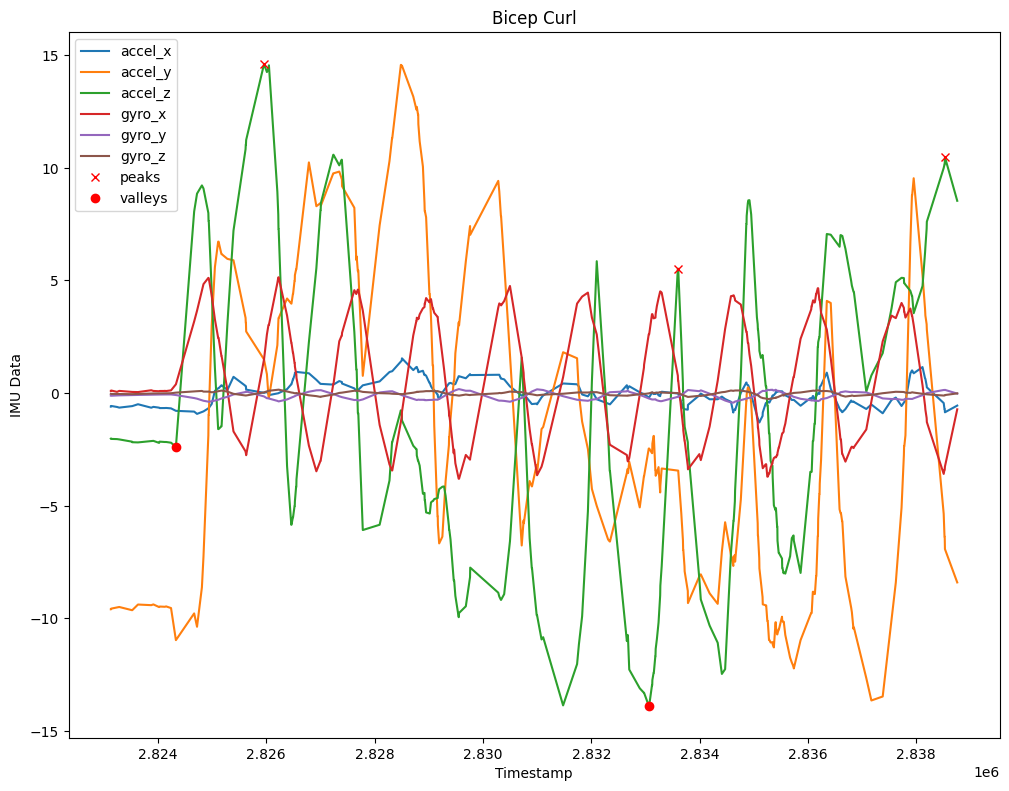

-8.132
valley_outlier_indices: [0 1]
10.192
peak_outlier_indices: []
valid_valley_idxs: []
valid_peak_idxs: [41, 181, 311]
start: 0, end: 313
num_valid_peaks: 3, num_valid_valleys: 0


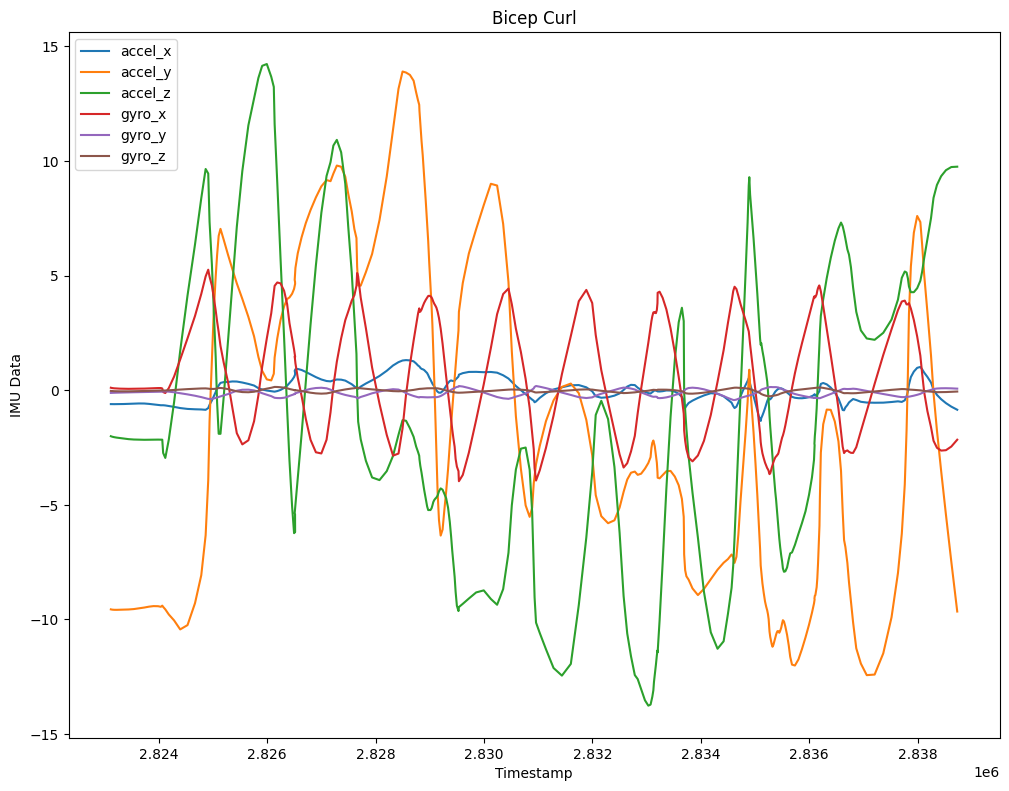

In [218]:
file = "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv"
df = create_df(file)
peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
plot_df(df, "Bicep Curl", peaks, valleys)
start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)

df = df.iloc[start:end]
df = smooth_and_resample(df)
plot_df(df, "Bicep Curl")

In [219]:
def cropped_df(file):
    df = create_df(file)
    peaks, valleys, peakvals, valleyvals = get_peaks_and_valleys(df, 120)
    start, end, num_peaks, num_valleys = get_num_reps(df, peakvals, valleyvals)
    # df = df.iloc[start:end]
    print(f"file: {file}, len(df): {len(df)}")
    return df

In [220]:
X_train = []
X_validation = []
X_test = []
max_len = 100

for f in training_files:
    print(f"train: {f}")
    df = cropped_df(f)
    df = smooth_and_resample(df)
    max_len = max(max_len, len(df))
    X_train.append(df)

for f in validation_files:
    print(f"validation: {f}")
    df = cropped_df(f)
    df = smooth_and_resample(df)
    max_len = max(max_len, len(df))
    X_validation.append(df)

for f in test_files:
    print(f"test: {f}")
    df = cropped_df(f)
    df = smooth_and_resample(df)
    max_len = max(max_len, len(df))
    X_test.append(df)

y_train = np.array(train_labels)
y_validation = np.array(validation_labels)
y_test = np.array(test_labels)

train: ../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     304079   -0.834    3.319    9.444   0.098  -0.054   0.012
1     304082   -0.824    3.326    9.452   0.098  -0.054   0.012
2     304085   -0.824    3.326    9.452   0.097  -0.053   0.012
3     304089   -0.824    3.326    9.452   0.097  -0.053   0.012
4     304110   -0.846    3.269    9.446   0.122  -0.056   0.007
peakvals: [(70, 11.841), (258, 12.548), (450, 12.47), (640, 12.22), (817, 12.367), (999, 12.099), (1188, 12.439), (1366, 12.207), (1562, 12.272), (1752, 12.193), (1910, 11.174)]
valleyvals: [(142, -5.234), (330, -7.138), (527, -7.144), (710, -7.452), (904, -7.908), (1075, -8.465), (1264, -9.249), (1455, -8.989), (1631, -8.171), (1821, -8.157)]
peaks: [  70  258  450  640  817  999 1188 1366 1562 1752 1910], peakvals: [(70, 11.841), (258, 12.548), (450, 12.47), (640, 12.22), (817, 12.367), (999, 12.099), (1

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12

   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0    1087528    0.754    6.828   -5.371  -0.420  -0.075  -0.084
1    1087532    0.754    6.828   -5.371  -0.580  -0.075  -0.061
2    1087535    0.754    6.828   -5.371  -0.580  -0.075  -0.061
3    1087539    0.793    5.792   -5.593  -0.701  -0.076  -0.049
4    1087622    1.004    6.267   -5.375  -0.419  -0.083  -0.119
peakvals: [(238, 10.307), (383, 18.817), (616, 20.338), (746, 17.42)]
valleyvals: [(33, -12.255), (158, -6.573)]
peaks: [238 383 616 746], peakvals: [(238, 10.307), (383, 18.817), (616, 20.338), (746, 17.42)]
valleys: [ 33 158], valleyvals: [(33, -12.255), (158, -6.573)]
-9.414000000000001
valley_outlier_indices: []
16.7205
peak_outlier_indices: [0]
valid_valley_idxs: [33, 158]
valid_peak_idxs: [383, 616, 746]
start: 383, end: 746
num_valid_peaks: 3, num_valid_valleys: 2
file: ../data2/squat/squat_udai_set3_reps10_1.csv, len(df): 793
test: ../data2/bicep_curl/bicep_adam_set2_reps10_1.csv
../data2/bicep_curl/b

/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12

In [221]:
print(f"max_len: {max_len}")

def pad(df, max_len):
    arr = df[['accel_x','accel_y','accel_z','gyro_x','gyro_y','gyro_z']].values
    print(len(arr))
    if len(arr) >= max_len:
        return arr[:max_len]
    else:
        pad = np.zeros((max_len - len(arr), 6))
        return np.vstack((arr, pad))



max_len: 300


In [222]:
X_train = np.array([pad(df, max_len) for df in X_train])
X_validation = np.array([pad(df, max_len) for df in X_validation])
X_test = np.array([pad(df, max_len) for df in X_test])

X_train = np.stack(X_train, axis=0)
X_validation = np.stack(X_validation, axis=0)
X_test = np.stack(X_test, axis=0)

num_classes = 5
y_train = to_categorical(y_train, num_classes)
y_validation = to_categorical(y_validation, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
X_train shape: (41, 300, 6)
y_train shape: (41, 5)
X_test shape: (36, 300, 6)
y_test shape: (36, 5)


In [223]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 296, 64)        │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 296, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 148, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 148, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,949 (605.27 KB)

 Trainable params: 154,821 (604.77 KB)

 Non-trainable params: 128 (512.00 B)

In [224]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4062 - loss: 1.5424 - val_accuracy: 0.0000e+00 - val_loss: 1.7252
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5000 - loss: 1.2503 - val_accuracy: 0.0000e+00 - val_loss: 1.7127
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5000 - loss: 1.1801 - val_accuracy: 0.0000e+00 - val_loss: 1.6279
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5938 - loss: 1.0020 - val_accuracy: 0.1111 - val_loss: 1.8172
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6250 - loss: 0.9329 - val_accuracy: 0.1111 - val_loss: 1.9333
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5938 - loss: 1.0059 - val_accuracy: 0.2222 - val_loss: 1.8711
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6875 - loss: 0.8072 - val_accuracy: 0.0000e+00 - val_loss: 1.8948
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7188 - loss: 0.6822 - val_accuracy: 0.0000e+0

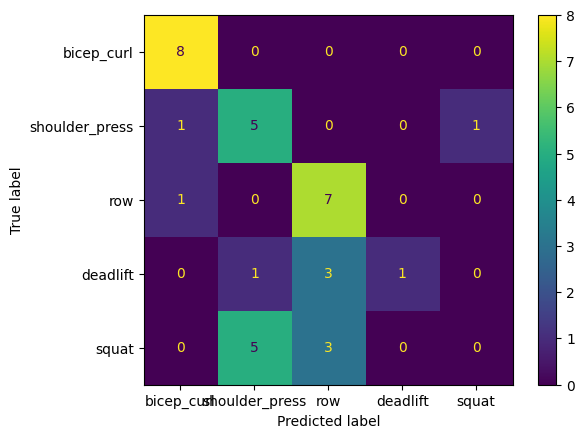

In [225]:
model.fit(
    X_train, y_train,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    epochs=30,
    batch_size=6,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()